In [ ]:
# Note: Please follow to the About Fastai section in the README to update the fastai accordingly

In [1]:
from fastai.tabular.all import *

# for feature generation and plotting
from cryspnet.utils import *
# for accessing some pre-defined constant
from cryspnet.config import *

import pandas as pd
import numpy as np

In [ ]:
@patch
def setups(self:FillMissing, dsets):
    missing = pd.isnull(dsets.conts).any()
    store_attr(but='dsets', na_dict={n:self.fill_strategy(dsets[n], self.fill_vals[n]) for n in missing[missing].keys()})
    self.fill_strategy = self.fill_strategy.__name__

In [2]:
df = pd.read_csv("../demo/demo_train.csv")

In [3]:
df.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0


# Generate features with matminer

In [4]:
fgenerator = FeatureGenerator()

In [5]:
df_predictors = fgenerator.generate(df)

StrToComposition:   0%|          | 0/280 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/280 [00:00<?, ?it/s]

In [6]:
df_predictors.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma,composition,...,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,NComp
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0,"(C, Hf, Ta, U)",...,0,0.0,0,0,0,0,0,0,0,4
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0,"(Co, Sb, Ta)",...,0,0.0,0,0,0,0,0,0,0,3
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0,"(Ge, Sb, Se, Te)",...,0,0.0,0,0,0,0,0,0,0,4
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0,"(C, Ni)",...,0,0.0,0,0,0,0,0,0,0,2
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0,"(Ir, Mg)",...,0,0.0,0,0,0,0,0,0,0,2


# Train models for space groups

In [7]:
groups = df_predictors.groupby("Bravais")

In [8]:
dep_var = "Space Group"

In [9]:
trn_cols = [dep_var] + list(df_predictors.columns[10:])

In [10]:
def initializer(df, dep_var, cont_names=[], cat_names=[], classes=None, k=3, p=0.1, is_oversample=False, n_oversample=None, bs=32):

    # split train and validation set and do oversampling if enabled
    val_idx= np.random.choice(df.index, int(len(df)*p), replace=False)
    if is_oversample:
        df, val_idx = oversample(df, val_idx, dep_var, nsamples=n_oversample)
    
    splits = IndexSplitter(val_idx)(df.index)
    
    # categorize
    
    if classes is None:
        classes = df[dep_var].unique()
        classes.sort()
    
    df[dep_var] = pd.Categorical(df[dep_var], categories=classes)
        
    # create datasets
    trn_cols = list(cont_names) + list(cat_names) + [dep_var]
    
    to = TabularPandas(df[trn_cols], procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names=dep_var,
                   splits=splits)
    
    # turn it into dataloader
    dls = to.dataloaders(bs=bs)
    
    # use the dataset to create the corresponding tabular learner
    # config allow us to tune the actual architecture
    # metrics are for evaluation
    config = tabular_config(ps=[0.0]+[0.1]*4, bn_cont=False, bn_final=True) # add drop out layer
    
    k = min(len(classes), k)    
    metrics = [partial(topkacc, k=k), accuracy]
    
    learn = tabular_learner(
        dls,
        layers=[256, 256, 256, 256], # set layer dimension
        metrics=metrics,
        config=config)
    
    learn.classes = classes # add classes to learn, important

    return learn

In [11]:
learner_folder = Path(LEARNER)
learner_folder.mkdir(exist_ok=True)
# metal or oxide subset is similar but just replace whole with metal or oxide
space_group_folder = learner_folder / SPACE_GROUP_MODELS_FOLDER
space_group_folder.mkdir(exist_ok=True)

Training a model on cubic (F) subset


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.2089296132326126)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.799312,463770.593750,1.000000,0.000000,00:00
1,0.752978,776863.375000,1.000000,0.000000,00:00
2,0.853449,758993.437500,1.000000,0.500000,00:00
3,0.869156,3433339.500000,1.000000,0.500000,00:00
4,0.776438,4088001.000000,1.000000,0.000000,00:00
5,0.707216,8184056.500000,1.000000,0.000000,00:00
6,0.588781,4008264.500000,1.000000,0.000000,00:00
7,0.594012,5456537.500000,1.000000,0.000000,00:00
8,0.518137,4282493.500000,1.000000,0.000000,00:00
9,0.443597,5618209.000000,1.000000,0.000000,00:00


Training a model on cubic (I) subset


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.2089296132326126)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.040696,18639636.000000,1.000000,0.000000,00:00
1,0.930241,0.000000,1.000000,1.000000,00:00
2,1.047789,21691136.000000,1.000000,0.500000,00:00
3,0.932746,0.000000,1.000000,1.000000,00:00
4,0.810982,0.000000,1.000000,1.000000,00:00
5,0.765590,0.000000,1.000000,1.000000,00:00
6,0.614021,85451712.000000,1.000000,0.000000,00:00
7,0.497306,0.000000,1.000000,1.000000,00:00
8,0.448005,0.000000,1.000000,1.000000,00:00
9,0.436090,108373392.000000,1.000000,0.000000,00:00


Training a model on cubic (P) subset


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.0831763744354248)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.934058,2249670.500000,0.500000,0.500000,00:00
1,0.811658,15444714.000000,1.000000,0.000000,00:00
2,0.957396,64953328.000000,1.000000,0.000000,00:00
3,0.848893,48990244.000000,1.000000,0.500000,00:00
4,0.678164,139863584.000000,1.000000,0.000000,00:00
5,0.572868,109793832.000000,1.000000,0.000000,00:00
6,0.412552,87249344.000000,1.000000,0.000000,00:00
7,0.326278,66709976.000000,1.000000,0.500000,00:00
8,0.296088,68377112.000000,1.000000,0.000000,00:00
9,0.216357,63877032.000000,1.000000,0.000000,00:00


Training a model on hexagonal (P) subset


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.007585775572806597)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.863465,67596600.000000,0.000000,0.000000,00:00
1,0.883620,463735200.000000,0.000000,0.000000,00:00
2,0.865235,1123115264.000000,1.000000,0.000000,00:00
3,0.951096,591599552.000000,1.000000,0.000000,00:00
4,0.854354,1653044480.000000,1.000000,0.000000,00:00
5,0.617734,2305720832.000000,0.500000,0.000000,00:00
6,0.580332,2851717888.000000,1.000000,0.000000,00:00
7,0.522577,2074300416.000000,0.500000,0.000000,00:00
8,0.395773,1930319104.000000,0.500000,0.000000,00:00
9,0.311983,798579456.000000,1.000000,0.000000,00:00


Training a model on monoclinic (C) subset


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.10000000149011612)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.528484,0.000000,1.000000,1.000000,00:00
1,0.590917,0.000000,1.000000,1.000000,00:00
2,0.721406,0.000000,1.000000,1.000000,00:00
3,0.705239,39870924.000000,1.000000,0.000000,00:00
4,0.619015,33133728.000000,1.000000,0.500000,00:00
5,0.504999,242771232.000000,1.000000,0.000000,00:00
6,0.468066,119806424.000000,1.000000,0.000000,00:00
7,0.390625,159660624.000000,1.000000,0.000000,00:00
8,0.279959,158926256.000000,1.000000,0.000000,00:00
9,0.271518,227794816.000000,1.000000,0.000000,00:00


Training a model on monoclinic (P) subset


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.000000,0.000000,1.000000,1.000000,00:00
1,0.000000,0.000000,1.000000,1.000000,00:00
2,0.000000,0.000000,1.000000,1.000000,00:00
3,0.000000,0.000000,1.000000,1.000000,00:00
4,0.000000,0.000000,1.000000,1.000000,00:00
5,0.000000,0.000000,1.000000,1.000000,00:00
6,0.000000,0.000000,1.000000,1.000000,00:00
7,0.000000,0.000000,1.000000,1.000000,00:00
8,0.000000,0.000000,1.000000,1.000000,00:00
9,0.000000,0.000000,1.000000,1.000000,00:00


Training a model on orthorhombic (C) subset


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=1.5848931980144698e-06)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.953308,4114.734375,1.000000,0.500000,00:00
1,0.879783,2178835.000000,1.000000,0.500000,00:00
2,0.846547,36257864.000000,1.000000,0.000000,00:00
3,0.954757,0.000000,1.000000,1.000000,00:00
4,0.908918,44303100.000000,1.000000,0.000000,00:00
5,0.676852,154248960.000000,1.000000,0.000000,00:00
6,0.649536,89168688.000000,1.000000,0.000000,00:00
7,0.469506,117442912.000000,1.000000,0.000000,00:00
8,0.471503,194834912.000000,1.000000,0.000000,00:00
9,0.416488,266778336.000000,1.000000,0.000000,00:00


Training a model on orthorhombic (F) subset


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=6.309573450380412e-07)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.653265,1301117.500000,1.000000,0.000000,00:00
1,0.729741,28627748.000000,1.000000,0.000000,00:00
2,0.758683,44345808.000000,1.000000,0.000000,00:00
3,0.853669,114940352.000000,1.000000,0.000000,00:00
4,0.698722,249559968.000000,1.000000,0.000000,00:00
5,0.652204,143932080.000000,1.000000,0.000000,00:00
6,0.479692,185522048.000000,1.000000,0.000000,00:00
7,0.305723,252090768.000000,1.000000,0.000000,00:00
8,0.280588,297872352.000000,1.000000,0.000000,00:00
9,0.247450,265325536.000000,1.000000,0.000000,00:00


Training a model on orthorhombic (I) subset


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.010964781977236271)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.768575,5121190.000000,1.000000,0.000000,00:00
1,0.828199,2123117.000000,1.000000,0.500000,00:00
2,0.851885,0.000000,1.000000,1.000000,00:00
3,0.787278,74874960.000000,1.000000,0.500000,00:00
4,0.796577,81065704.000000,1.000000,0.000000,00:00
5,0.772090,50153544.000000,1.000000,0.500000,00:00
6,0.610765,39672312.000000,1.000000,0.000000,00:00
7,0.452124,57234584.000000,1.000000,0.500000,00:00
8,0.468886,41579848.000000,1.000000,0.500000,00:00
9,0.383795,53158076.000000,1.000000,0.500000,00:00


Training a model on orthorhombic (P) subset


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.3630780577659607)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.841319,0.000000,1.000000,1.000000,00:00
1,0.739110,5208411.500000,1.000000,0.000000,00:00
2,0.787329,6781569.000000,1.000000,0.000000,00:00
3,0.853066,16270704.000000,1.000000,0.000000,00:00
4,0.754945,29853124.000000,1.000000,0.000000,00:00
5,0.566804,45881456.000000,1.000000,0.000000,00:00
6,0.451964,2962068.250000,1.000000,0.000000,00:00
7,0.381406,10330159.000000,1.000000,0.000000,00:00
8,0.327068,5876315.500000,1.000000,0.000000,00:00
9,0.234953,4271117.000000,1.000000,0.000000,00:00


Training a model on rhombohedral (P) subset


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.005248074419796467)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.924013,150010.859375,0.500000,0.000000,00:00
1,0.943297,2376733.750000,0.000000,0.000000,00:00
2,0.979648,8729887.000000,0.500000,0.000000,00:00
3,1.162484,18851902.000000,0.000000,0.000000,00:00
4,0.936215,5307347.500000,0.000000,0.000000,00:00
5,0.866087,5841486.500000,1.000000,0.500000,00:00
6,0.719961,7362799.500000,1.000000,0.000000,00:00
7,0.540911,2363044.250000,0.500000,0.000000,00:00
8,0.402175,1180249.625000,1.000000,0.000000,00:00
9,0.447278,3581060.250000,1.000000,0.000000,00:00


Training a model on tetragonal (I) subset


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.04786301031708717)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.578638,1004842.250000,1.000000,0.500000,00:00
1,0.628739,544104.000000,1.000000,0.500000,00:00
2,0.523369,9604358.000000,1.000000,0.500000,00:00
3,0.453468,55575712.000000,1.000000,0.500000,00:00
4,0.398950,38188892.000000,1.000000,0.500000,00:00
5,0.334878,54763280.000000,1.000000,0.500000,00:00
6,0.244689,33040532.000000,1.000000,0.500000,00:00
7,0.211160,46251648.000000,1.000000,0.500000,00:00
8,0.195928,40430152.000000,1.000000,0.500000,00:00
9,0.157751,24582424.000000,1.000000,0.500000,00:00


Training a model on tetragonal (P) subset


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.019054606556892395)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.969738,1127070.250000,1.000000,0.000000,00:00
1,0.880428,2638541.000000,1.000000,0.000000,00:00
2,0.859783,28856300.000000,1.000000,0.000000,00:00
3,0.913983,75573936.000000,1.000000,0.000000,00:00
4,0.971434,42825368.000000,1.000000,0.000000,00:00
5,0.745029,33966776.000000,1.000000,0.000000,00:00
6,0.580701,115273552.000000,1.000000,0.000000,00:00
7,0.524150,283101504.000000,1.000000,0.000000,00:00
8,0.466693,350700800.000000,1.000000,0.000000,00:00
9,0.410101,303601280.000000,1.000000,0.000000,00:00


Training a model on triclinic (P) subset


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.000000,0.000000,1.000000,1.000000,00:00
1,0.000000,0.000000,1.000000,1.000000,00:00
2,0.000000,0.000000,1.000000,1.000000,00:00
3,0.000000,0.000000,1.000000,1.000000,00:00
4,0.000000,0.000000,1.000000,1.000000,00:00
5,0.000000,0.000000,1.000000,1.000000,00:00
6,0.000000,0.000000,1.000000,1.000000,00:00
7,0.000000,0.000000,1.000000,1.000000,00:00
8,0.000000,0.000000,1.000000,1.000000,00:00
9,0.000000,0.000000,1.000000,1.000000,00:00


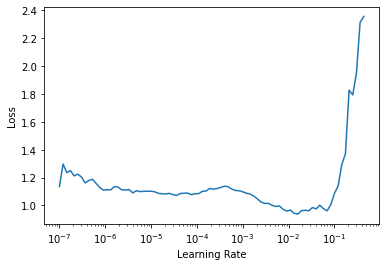

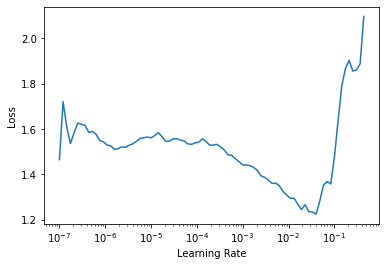

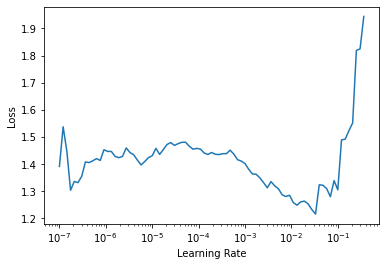

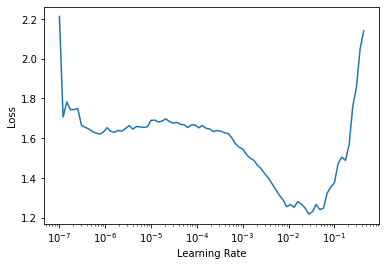

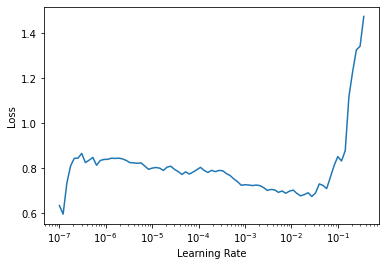

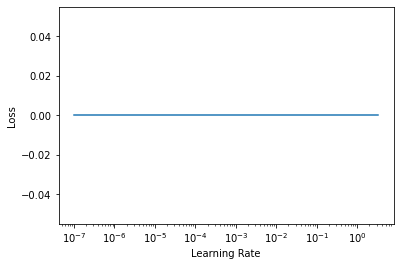

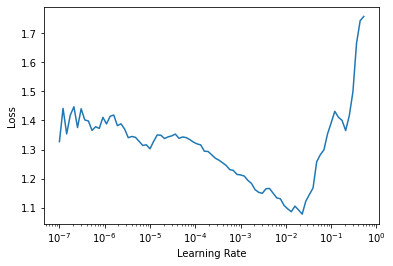

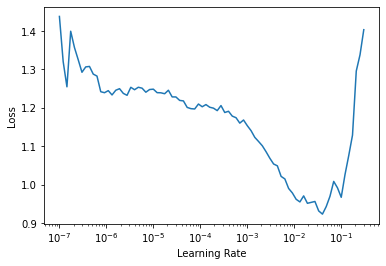

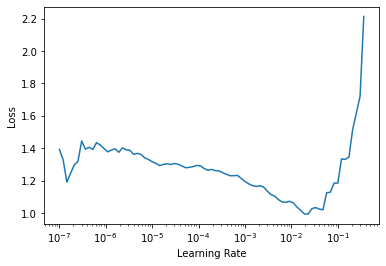

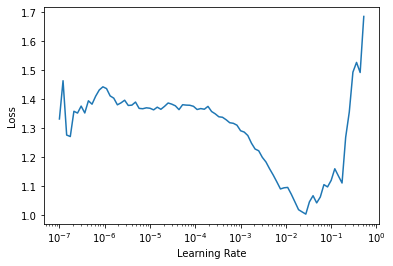

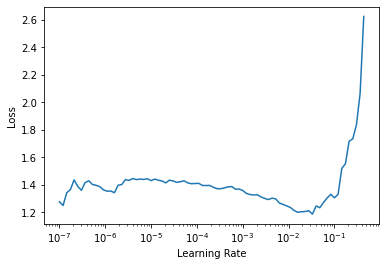

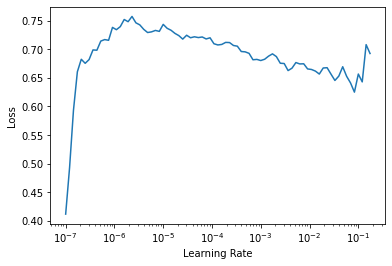

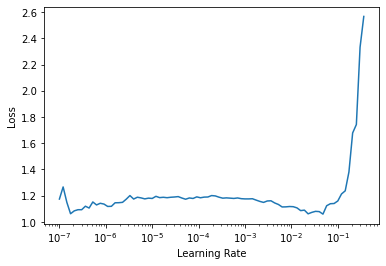

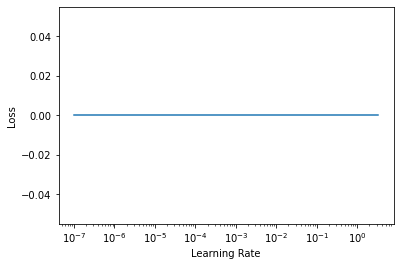

In [12]:
# learns = {}

for Bravais, group in groups:
    print(f"Training a model on {Bravais} subset")
    group = group.reset_index(drop=True)
    
    # remove entries with space group that only occur once in the dataset 
    vc = group['Space Group'].value_counts()
    single_sg = vc.index[vc==1]
    group = group.loc[ group['Space Group'].map(lambda x: x not in single_sg) ]
        
    learn = initializer(group, dep_var, cont_names=trn_cols[1:], is_oversample=True, n_oversample=100, p=0.2, bs=4)
    suggestions = learn.lr_find(suggestions=True)
    print(suggestions)
    # lr_max = suggestions.lr_steep
    lr_max = 1e-2
    learn.fit_one_cycle(10, lr_max=lr_max)
    learn.export(space_group_folder / f"{Bravais}.pkl")
#     learns[Bravais] = learn